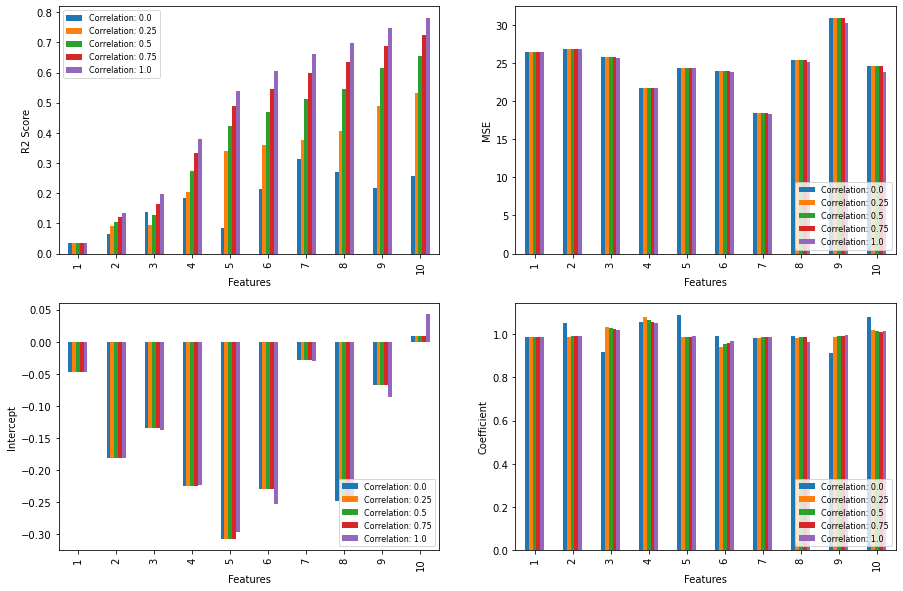

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Code to generate a multivariate dataset.
def make_regression_multivariate(
    n_samples,
    n_uncorrelated,
    n_correlated,
    correlation,
    weights,
    bias,
    noise=1,
    seed=42,
):
    np.random.seed(seed)

    # First, generate data of the correlated features.
    X_correlated = None
    if n_correlated > 0:
        # Compute the covariance matrix.
        cov = correlation * np.ones((n_correlated, n_correlated)) + (
            1 - correlation
        ) * np.eye(n_correlated)

        # Generate data using the covariance matrix.
        X_correlated = np.random.multivariate_normal(
            mean=np.zeros(n_correlated),
            cov=cov,
            size=n_samples,
        )

    # Second, generate data of the uncorrelated features (if any)
    X_uncorrelated = None
    if n_uncorrelated > 0:
        # Covariance martix is just identity matrix.
        X_uncorrelated = np.random.multivariate_normal(
            mean=np.zeros(n_uncorrelated), cov=np.eye(n_uncorrelated), size=n_samples
        )

    # Combine correlated and uncorrelated datasets if needed.
    X = None
    if n_uncorrelated <= 0:
        X = X_correlated
    elif n_correlated <= 0:
        X = X_uncorrelated
    else:
        X = np.hstack([X_correlated, X_uncorrelated])

    # Generate noise.
    e = np.random.normal(loc=0, scale=noise, size=n_samples)
    # Compute the target dataset using the features dataset, adding on bias and noise.
    y = bias + np.dot(X, weights) + e

    return X, y


performance = {
    "R2 Score": [],
    "MSE": [],
    "Intercept": [],
    "Coefficient": [],
}
features = []

for n_features in range(1, 11):
    features.append(n_features)
    performance["R2 Score"].append([])
    performance["MSE"].append([])
    performance["Intercept"].append([])
    performance["Coefficient"].append([])

    for correlation in range(0, 5, 1):
        weights = [1 for i in range(n_features)]
        # Generate regression dataset
        X, y = make_regression_multivariate(
            n_samples=int(5000 / n_features),
            n_uncorrelated=0,
            n_correlated=n_features,
            correlation=correlation / 4,
            weights=weights,
            bias=0,
            noise=5,
            seed=42,
        )

        X_df = pd.DataFrame(X)
        y_df = pd.DataFrame(y)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        regressor = LinearRegression()
        regressor.fit(X_train, y_train)

        y_pred = regressor.predict(X_test)

        coefficient_accuracy = np.sum(regressor.coef_) / (1 * n_features)

        performance["R2 Score"][n_features - 1].append(
            round(metrics.r2_score(y_test, y_pred), 3)
        )
        performance["MSE"][n_features - 1].append(
            round(metrics.mean_squared_error(y_test, y_pred), 3)
        )
        performance["Intercept"][n_features - 1].append(round(regressor.intercept_, 3))
        performance["Coefficient"][n_features - 1].append(
            round(coefficient_accuracy, 3)
        )

categories = [
    "Correlation: 0.0",
    "Correlation: 0.25",
    "Correlation: 0.5",
    "Correlation: 0.75",
    "Correlation: 1.0",
]

fig, axs = plt.subplots(2, 2)

pd.DataFrame(
    performance["R2 Score"],
    columns=categories,
    index=features,
).plot(kind="bar", figsize=(15, 10), ax=axs[0, 0])
axs[0, 0].set_xlabel("Features")
axs[0, 0].set_ylabel("R2 Score")
axs[0, 0].legend(loc="upper left", prop={"size": 8})

pd.DataFrame(
    performance["MSE"],
    columns=categories,
    index=features,
).plot(kind="bar", figsize=(15, 10), ax=axs[0, 1])
axs[0, 1].set_xlabel("Features")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].legend(loc="lower right", prop={"size": 8})

pd.DataFrame(
    performance["Intercept"],
    columns=categories,
    index=features,
).plot(kind="bar", figsize=(15, 10), ax=axs[1, 0])
axs[1, 0].set_xlabel("Features")
axs[1, 0].set_ylabel("Intercept")
axs[1, 0].legend(loc="lower right", prop={"size": 8})

pd.DataFrame(
    performance["Coefficient"],
    columns=categories,
    index=features,
).plot(kind="bar", figsize=(15, 10), ax=axs[1, 1])
axs[1, 1].set_xlabel("Features")
axs[1, 1].set_ylabel("Coefficient")
axs[1, 1].legend(loc="lower right", prop={"size": 8})

plt.show()